This is the first notebook for quantification of FISH expression. In here we quantify intensity in 
various forms (histograms of spot intensities, spot sizes and summed spot intensities).
We also quantify the SNR, the signal to noise ratio and the background.


23/04/25     Jacques Bourg @ Florian Muller lab. Institut Pasteur.


<div style="background-color: white; padding: 10px;">
    <img src="./pipeline.png" alt="pipeline" width="1200" height="420">
</div>

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import napari

import ipywidgets as widgets
from IPython.display import display

In [2]:
%load_ext autoreload
%autoreload 2
     
base_dir = Path("../../pipeline/src").resolve()
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "utils"))
sys.path.append(str(base_dir / "detection_fish"))
sys.path.append(str(base_dir / "segmentation"))
sys.path.append(str(base_dir / "synthesis"))

from utils.parameters_tracking import Parameter_tracking as Track
from utils.plots import Plots
from utils.file_handling import FileProcessor
from segmentation.refine_seg import Segmentation
from synthesis.synthesize import Synthesis

tk  = Track()
sg  = Segmentation()
pt  = Plots()
st  = Synthesis()
fp  = FileProcessor()

In [3]:
var = str(Path('../Analysis'))
batch_folders = os.listdir(var)
dropdown = widgets.Dropdown(options=batch_folders, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('kraken',), value='kr…

In [4]:
n         = np.where(np.array(batch_folders) == dropdown.value)[0][0]
file_path = str(Path(var) / Path(batch_folders[n]) / Path(batch_folders[n] +'.json'))
constants = tk.load_json(file_path)
batch_name= constants['BATCH_NAME']

In [5]:
modalities = constants['MODALITIES']
dropdown2 = widgets.Dropdown(options=modalities, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown2)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('KRAKEN',), value='KR…

In [6]:
n2       = np.where(np.array(modalities) == dropdown2.value)[0][0]
modality = modalities[n2]; print(modality)

KRAKEN


In [7]:
channels_cell = constants['CHANNELS']
dropdown3 = widgets.Dropdown(options=channels_cell, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'));
display(dropdown3)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'FISH'), valu…

In [8]:
n3     = np.where(np.array(channels_cell) == dropdown3.value)[0][0]
chan_c = channels_cell[n3]
print(chan_c)
col_channels = constants['COLORS']  # associated color to this channel
color        = col_channels[n3]; print(color)

FISH
green


In [9]:
channels_fish = constants['CHANNELS']
dropdown3b = widgets.Dropdown(options=channels_fish, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'));
display(dropdown3b)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'FISH'), valu…

In [10]:
n3b     = np.where(np.array(channels_fish) == dropdown3b.value)[0][0]
chan_f  = channels_fish[n3b]
print(chan_f)
col_channels = constants['COLORS']  # associated color to this channel
color        = col_channels[n3b]; print(color)

FISH
green


In [11]:
detection_methods = ['UFISH','BIGFISH']
dropdown4         = widgets.Dropdown(options=detection_methods, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown4)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('UFISH', 'BIGFISH'), …

In [12]:
n4     = np.where(np.array(detection_methods) == dropdown4.value)[0][0]
method = detection_methods[n4]; print(method)

BIGFISH


In [13]:
folder_path_figures = Path(f"../Analysis/{batch_name}/Figures") # create folder for figures (all figures will be stored there)
if not folder_path_figures.exists():
    folder_path_figures.mkdir(parents=True)

#### Spot intensity: extract intensity, spot size, summed spot intensity over estimated size.

In [14]:
batch_fish         = constants[f'BATCH_{modality}_{chan_f}']

dots_path          = constants[f'DOTS_{method}_{modality}_{chan_f}_PATH']
dict_dots          = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

window_size        = 7      # This parameter is critical
n_int_points       = 11
median_filt_size   = 4
frac               = 0.25   # This parameter is critical. 
#   Anyhow validate visually afterwards with the napari window. Iterate until the dot size estimation makes sense visually.

voxel_size_z       = constants[f'VOXEL_SIZE_NM_BF_{modality}_{chan_f}_Z'] 
voxel_size_yx      = constants[f'VOXEL_SIZE_NM_BF_{modality}_{chan_f}_YX']
obj_rad_z          = constants[f'OBJECT_RADIUS_NM_BF{modality}_{chan_f}_Z']
obj_rad_yx         = constants[f'OBJECT_RADIUS_NM_BF{modality}_{chan_f}_YX']

voxel_size_nm      = (voxel_size_z, voxel_size_yx, voxel_size_yx)  # important parameter: might be seen opening the image information in fiji or loooking at the microscope metadata.
object_radius_nm   = (obj_rad_z, obj_rad_yx, obj_rad_yx)

In [20]:
for ind_l, file in enumerate(batch_fish):
    im_rna                   = io.imread(Path(file))   
    file_name                = Path(file).stem     
    filebase_name            = '_'.join(file_name.split('_')[:-1])

    df_spots_filt            = dict_dots[filebase_name]
    df_w_intensity           = sg.extract_intensities_df(df_spots_filt, im_rna) 
    df_w_frac_signal         = sg.determine_spots_width_frac_signal_df(im_rna, df_w_intensity, h_window=window_size, size_median_filt=median_filt_size, frac=frac)
    df_w_sum_intensity       = sg.compute_sum_spot_intensity_df(df_w_frac_signal, im_rna)
    dict_dots[filebase_name] = st.compute_snr_df(im_rna, df_w_sum_intensity, voxel_size_nm, object_radius_nm)    

fp.save_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'], dict_dots, im_rna.ndim)

#### Manual step      (WARNING: Manual input required)
Organize your batch in rows and columns: rows can be conditions, and columns time or rows can be repetitions and columns conditions
store as (line, column) for each element of the batch. Put None in case you don't want to display it. 
For instance if your batch files is ['file_control0', 'file_control1', 'file_control2', 'file_rep1_c1', 'file_rep2_c1', 'file_rep1_c2', 'file_rep2_c2'] and you want to organize your 
display as:

|          | Concentration 1 | Concentration 2 |
|----------|----------|----------|
| **Rep 1**| R1, C1   | R1, C2   | 
| **Rep 2**| R2, C1   | R2, C2   |


Then, insert the coordinates, in the following way,  do for a batch of experiments like:

batch      = [`Exp to discard`, `Exp to discard`, `Exp to discard`, `R1,C1`, `R2,C1`,`R1,C2`,  `R2,C2` ]

batch_plot = [`None` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,  `None`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,  `None `&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,`(0,0) `,`(1,0) `,`(0,1) `,`(1,1)`]

In [15]:
prefix = '2025-08-25_Kraken-Papier3_D_R1_r1'

import pandas as pd
def extract_df_from_round_i(prefix, dict_dots: dict, ):
    matching_keys = [key for key in dict_dots.keys() if key.startswith(prefix)]
    df_to_concat = []
    for key in matching_keys:
        if len(dict_dots[key]):
            df_to_concat.append(dict_dots[key])
    final_df = pd.concat(df_to_concat, ignore_index=True)
    return final_df

def extract_non_nan_given_col(df: pd.DataFrame, col_name: str):
    arr = df[df[col_name].notna()][col_name].to_numpy()
    return arr

In [16]:
pref_base = '2025-08-25_Kraken-Papier3_D_R1'

prefix = pref_base + '_r1'
df_r1  = extract_df_from_round_i(prefix, dict_dots)
int_r1 = extract_non_nan_given_col(df_r1, 'intensity')
back_r1 = extract_non_nan_given_col(df_r1, 'background')

prefix = pref_base + '_r3'
df_r3  = extract_df_from_round_i(prefix, dict_dots)
int_r3 = extract_non_nan_given_col(df_r3, 'intensity')
back_r3 = extract_non_nan_given_col(df_r3, 'background')

prefix = pref_base + '_r7'
df_r7  = extract_df_from_round_i(prefix, dict_dots)
int_r7 = extract_non_nan_given_col(df_r7, 'intensity')
back_r7 = extract_non_nan_given_col(df_r7, 'background')

prefix = pref_base + '_r2'
df_r2  = extract_df_from_round_i(prefix, dict_dots)
int_r2 = extract_non_nan_given_col(df_r2, 'intensity')
back_r2 = extract_non_nan_given_col(df_r2, 'background')

prefix = pref_base + '_r5'
df_r5  = extract_df_from_round_i(prefix, dict_dots)
int_r5 = extract_non_nan_given_col(df_r5, 'intensity')
back_r5 = extract_non_nan_given_col(df_r5, 'background')

prefix = pref_base + '_r8'
df_r8  = extract_df_from_round_i(prefix, dict_dots)
int_r8 = extract_non_nan_given_col(df_r8, 'intensity')
back_r8 = extract_non_nan_given_col(df_r8, 'background')

data_xpo1   = [int_r1, back_r1, int_r3, back_r3, int_r7, back_r7]
data_kraken = [int_r2, back_r2, int_r5, back_r5, int_r8, back_r8]
custom_positions = [0.8, 1.2, 1.8, 2.2, 2.8, 3.2] 
colors           = ['#94c9de00', '#F3CFB6', '#94c9deff', '#F3CFB6', '#94c9deff', '#F3CFB6'] # lightblue bisque  #94c9de

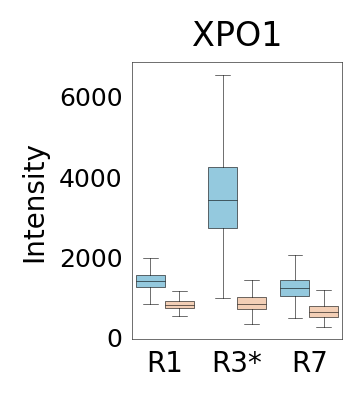

In [17]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
thin_line_properties = {
    'linewidth': 0.2  # Set the desired linewidth here
}


fig, ax = plt.subplots(figsize=(1.35, 1.8), dpi=200)
bp = ax.boxplot(
    data_xpo1,
    boxprops=thin_line_properties,
    whiskerprops=thin_line_properties,
    capprops=thin_line_properties,
    positions=custom_positions, # <-- Set your custom positions here
    medianprops={'linewidth': 0.2, 'color': 'red'},
    vert=True,
    patch_artist=True,
    showfliers=False,
    whis=1.5,
    widths=0.4
)

for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    box.set_edgecolor('black')
    box.set_alpha(1)
    
median_colors = ['black']
for median in bp['medians']:
    median.set_color('black')

ax.set_ylabel('Intensity',fontsize=10)

new_tick_positions = [1, 2, 3]
ax.set_xticks(new_tick_positions)
new_labels = ['R1', 'R3*', 'R7']
ax.set_xlim([0.55, 3.45])
ax.set_xticklabels(new_labels, fontsize=10);
ax.tick_params(axis='y', labelsize=9,  length=0.0)
ax.set_title('XPO1');
ax.tick_params(axis='x', length=0.0)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(0.2)


fig.savefig('xpo1_spot_intensity_V4.svg')

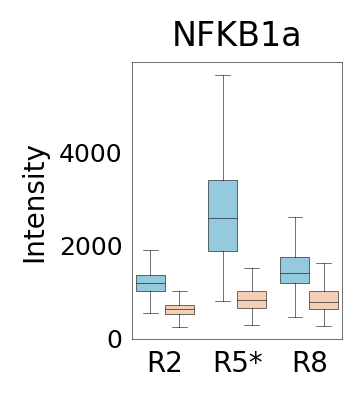

In [18]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
thin_line_properties = {
    'linewidth': 0.2  # Set the desired linewidth here
}


fig, ax = plt.subplots(figsize=(1.35, 1.8), dpi=200)
bp = ax.boxplot(
    data_kraken,
    boxprops=thin_line_properties,
    whiskerprops=thin_line_properties,
    capprops=thin_line_properties,
    positions=custom_positions, # <-- Set your custom positions here
    medianprops={'linewidth': 0.2, 'color': 'red'},
    vert=True,
    patch_artist=True,
    showfliers=False,
    whis=1.5,
    widths=0.4
)

for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
    box.set_edgecolor('black')
    box.set_alpha(1)
    
median_colors = ['black']
for median in bp['medians']:
    median.set_color('black')

ax.set_ylabel('Intensity',fontsize=10)

new_tick_positions = [1, 2, 3]
ax.set_xticks(new_tick_positions)
new_labels = ['R2', 'R5*', 'R8']
ax.set_xlim([0.55, 3.45])
ax.set_xticklabels(new_labels, fontsize=10);
ax.tick_params(axis='y', labelsize=9,  length=0.0)
ax.set_title('NFKB1a');
ax.tick_params(axis='x', length=0.0)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(0.2)


fig.savefig('nfkb1a_spot_intensity_V4.svg')

#### Save constants

In [33]:
WINDOW_SIZE        = window_size
N_INT_POINTS       = n_int_points
FRAC               = frac
MEDIAN_FILT_SIZE   = median_filt_size

In [34]:
constants2 = tk.collect_constants()
tk.save_constants_and_commit_hash(constants2, batch_name, folder_path = Path(f"../Analysis/{batch_name}"))